https://www.kaggle.com/code/prashant111/arima-model-for-time-series-forecasting

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

data = pd.read_csv('dataset.csv')
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(data['value'])
plt
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

data.value


In [12]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from pmdarima.model_selection import train_test_split


/home/fana/Documents/DOCKER/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/fana/Documents/DOCKER/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/fana/Documents/DOCKER/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/fana/Documents/DOCKER/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/fana/Documents/DOCKER/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finit

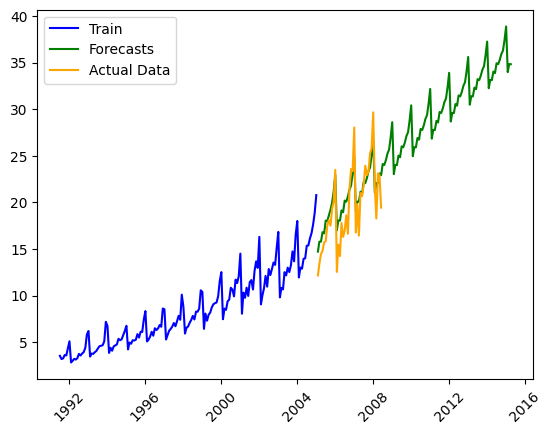

In [26]:
train, test = train_test_split(data.value, train_size=0.8)
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,)

forecasts = model.predict(test.shape[0]*3)  # predict N steps into the future

# Add the date to the x-axis for better visualization
x_train_dates = train.index
x_forecasts_dates = pd.date_range(start=test.index[0], periods=len(forecasts), freq='MS')
x_actual_dates = test.index

plt.plot(x_train_dates, train, c='blue', label='Train')
plt.plot(x_forecasts_dates, forecasts, c='green', label='Forecasts')
plt.plot(x_actual_dates, test, c='orange', label='Actual Data')
plt.legend()
plt.xticks(rotation=45)
plt.show()

Best order: (0, 1, 0)
Best seasonal order: (0, 1, 1, 12)


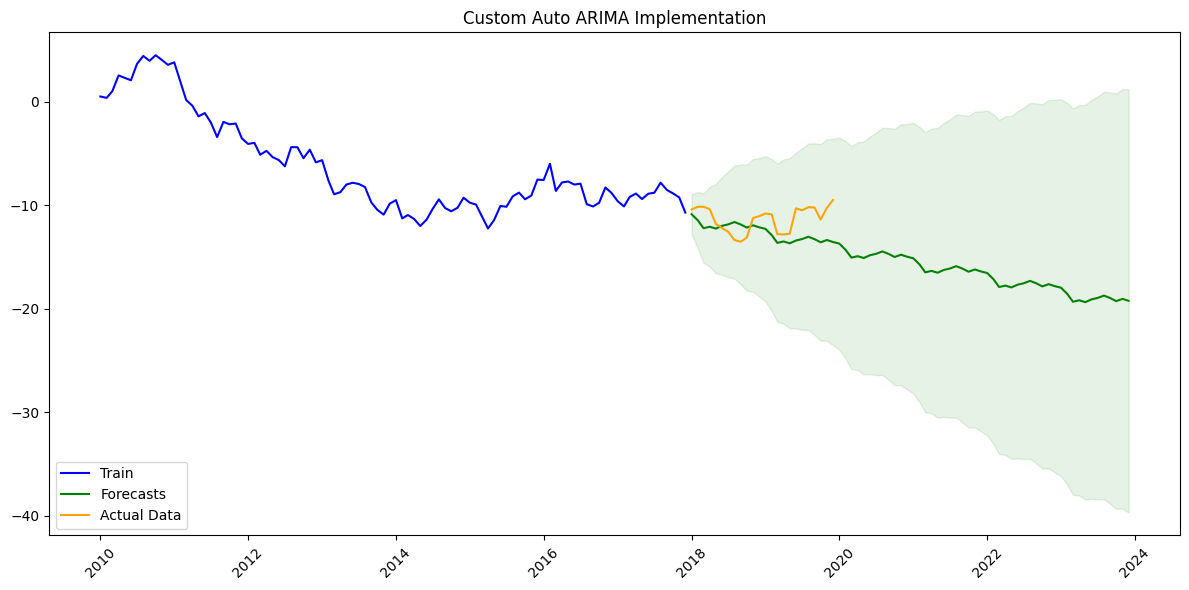

Test RMSE: 1.96


In [27]:
import itertools
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt

def auto_arima(train, seasonal=True, m=12, max_p=3, max_q=3, max_d=2, max_P=1, max_Q=1, max_D=1):
    """
    Custom implementation of auto ARIMA without pmdarima
    
    Parameters:
    - train: training data (pandas Series with datetime index)
    - seasonal: whether to consider seasonal components
    - m: seasonal period
    - max_p: max non-seasonal AR order
    - max_q: max non-seasonal MA order
    - max_d: max non-seasonal differencing
    - max_P: max seasonal AR order
    - max_Q: max seasonal MA order
    - max_D: max seasonal differencing
    
    Returns:
    - best_model: fitted SARIMAX model with best parameters
    - best_order: best (p,d,q) order
    - best_seasonal_order: best (P,D,Q,m) order
    """
    
    # Determine optimal d via ADF test
    def _get_d(y):
        p_val = 1
        d = 0
        while p_val > 0.05:
            adf_result = adfuller(y)
            p_val = adf_result[1]
            if p_val > 0.05:
                y = np.diff(y)
                d += 1
            if d >= max_d:
                break
        return d
    
    d = _get_d(train)
    
    if not seasonal:
        # Non-seasonal ARIMA
        p_range = range(0, max_p+1)
        q_range = range(0, max_q+1)
        
        best_aic = np.inf
        best_order = None
        best_model = None
        
        for p, q in itertools.product(p_range, q_range):
            if p == 0 and q == 0:
                continue
                
            try:
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore")
                    model = SARIMAX(train, order=(p,d,q))
                    results = model.fit(disp=False)
                    
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = (p,d,q)
                        best_model = results
                        
            except:
                continue
                
        return best_model, best_order, None
    
    else:
        # Seasonal ARIMA (SARIMA)
        p_range = range(0, max_p+1)
        q_range = range(0, max_q+1)
        P_range = range(0, max_P+1)
        Q_range = range(0, max_Q+1)
        D_range = [0, 1]  # Typically just 0 or 1 for seasonal differencing
        
        best_aic = np.inf
        best_order = None
        best_seasonal_order = None
        best_model = None
        
        # Try all combinations
        for p, q, P, Q, D in itertools.product(p_range, q_range, P_range, Q_range, D_range):
            if p == 0 and q == 0 and P == 0 and Q == 0:
                continue
                
            try:
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore")
                    model = SARIMAX(train, 
                                  order=(p,d,q), 
                                  seasonal_order=(P,D,Q,m))
                    results = model.fit(disp=False)
                    
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = (p,d,q)
                        best_seasonal_order = (P,D,Q,m)
                        best_model = results
                        
            except:
                continue
                
        return best_model, best_order, best_seasonal_order

# Example usage
if __name__ == "__main__":
    # Load your data (replace with your actual data)
    # data = pd.read_csv('your_data.csv', parse_dates=['date'], index_col='date')
    # For demonstration, let's create some dummy data
    np.random.seed(42)
    dates = pd.date_range(start='2010-01-01', periods=120, freq='MS')
    data = pd.Series(np.random.randn(120).cumsum(), index=dates)
    
    # Split data
    train_size = int(len(data) * 0.8)
    train, test = data[:train_size], data[train_size:]
    
    # Run our custom auto_arima
    best_model, best_order, best_seasonal_order = auto_arima(
        train, 
        seasonal=True, 
        m=12,
        max_p=3, 
        max_q=3,
        max_P=1,
        max_Q=1
    )
    
    print(f"Best order: {best_order}")
    print(f"Best seasonal order: {best_seasonal_order}")
    
    # Forecast
    forecast_steps = len(test) * 3  # forecast 3x test length
    forecasts = best_model.get_forecast(steps=forecast_steps)
    forecast_values = forecasts.predicted_mean
    conf_int = forecasts.conf_int()
    
    # Plot results
    x_train_dates = train.index
    x_forecasts_dates = pd.date_range(start=test.index[0], periods=forecast_steps, freq='MS')
    x_actual_dates = test.index
    
    plt.figure(figsize=(12, 6))
    plt.plot(x_train_dates, train, c='blue', label='Train')
    plt.plot(x_forecasts_dates, forecast_values, c='green', label='Forecasts')
    plt.fill_between(x_forecasts_dates, 
                    conf_int.iloc[:, 0], 
                    conf_int.iloc[:, 1], 
                    color='green', alpha=0.1)
    plt.plot(x_actual_dates, test, c='orange', label='Actual Data')
    plt.legend()
    plt.xticks(rotation=45)
    plt.title('Custom Auto ARIMA Implementation')
    plt.tight_layout()
    plt.show()
    
    # Calculate RMSE for test period
    test_forecast = forecast_values[:len(test)]
    rmse = sqrt(mean_squared_error(test, test_forecast))
    print(f"Test RMSE: {rmse:.2f}")